### Motivation
In this notebook, I'm going to built a LSTM model to predict views trending of vidoes from Trending YouTube Video Statistic dataset. There are lots of data from different countries. I only use US videos as demo. You can also predict likes, dislikes or comment counts in a similar way while I only use views prediction as demo. Feel free to amend the code and try something new. I have tried several senarios and found something interesting. I hope you like it .Let's get started.

In [324]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Data Read and Exploration

There are two group of data files, videos data file and category data file.

In [325]:
filepath1="/kaggle/input/youtube-new/US_category_id.json"
category_id_df = pd.read_json(filepath1)
category_id_df.head()

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
3,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
4,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


In [326]:
filepath2="/kaggle/input/youtube-new/USvideos.csv"
videos_df = pd.read_csv(filepath2,header='infer')
videos_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


If you want to load data to relational database for later analysis. You may encounter some problems due to unnecessary chars like '"' ',' '\r' in title,description and channel title columns. You have to remove all these problematic chars. Be careful that each country may have different chars need to be removed. We only take US dataset as an example.

In [327]:
def clean_video_csv(video_df,country_code):
    """
    This function is to remove unnecessary chars like '"',',','\r'which will cause errors when copy csv files into staging table.
    
    Parameters:
    video_df: Dataframe from read_csv file
    filepath: videos csv filepath
    
    Return:
    video_df: Dataframe which remove unnecessary chars
    """
    video_df["tags"] = video_df["tags"].apply(lambda x:x.replace('"',""))
    video_df["title"] = video_df["title"].apply(lambda x:x.replace(',',' '))
    video_df["channel_title"] = video_df["channel_title"].apply(lambda x:x.replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('\r',''))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('"',''))
    video_df["country"] = country_code
    return video_df
#Clean videos csv files for selected country code
country_code=['US']
for c in country_code:
    filepath="/kaggle/input/youtube-new/"+c+"videos.csv"
    video_df = pd.read_csv(filepath,header='infer')
    savepath = "/kaggle/working/"+c+"videos1.csv"
    video_df = clean_video_csv(video_df,c)
    video_df.to_csv(savepath,index=False)

Since category id in different countries are not the same, we have to extract categoty id and titles from json file of each country and save it as a csv file for later use. 

In [328]:
def category_extract (df,country_code):
    """
    The function is to extract category id and category title from category_id json files
    
    Parameters:
    df: Dataframe of read_json file
    filepath: category_id json filepath
    
    Return:
    category_df: Dataframe with columns: category_id,category_title,category_filename,country_code
    
    """
    category_id = []
    category_title = []
    for i in range(df.shape[0]):
        category_id.append(df.iloc[i]["items"]['id'])
        category_title.append(df.iloc[i]["items"]["snippet"]["title"])
    category_df = pd.DataFrame()
    category_df["category_id"] = category_id
    category_df["category_title"] = category_title
    category_df.insert(category_df.shape[1],"country_code",country_code)
    return category_df

#Extract category title and id from json file of each country

category_all = pd.DataFrame()
for c in country_code:
    filepath="/kaggle/input/youtube-new/"+c+"_category_id.json"
    category_id_df = pd.read_json(filepath)
    category_all = pd.concat([category_all,category_extract(category_id_df,c)])
    
#category_all.tail()
savepath = "/kaggle/working/category_all.csv"
category_all.to_csv(savepath,index=False)

In [329]:
US = pd.read_csv("/kaggle/working/USvideos1.csv")
US.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,last week tonight trump presidency|last week t...,2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,One year after the presidential election John...,US
2,5qpjK5DgCt4,17.14.11,Racist Superman | Rudy Mancuso King Bach & Le...,Rudy Mancuso,23,2017-11-12T19:05:24.000Z,racist superman|rudy|mancuso|king|bach|racist|...,3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,US
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,rhett and link|gmm|good mythical morning|rhett...,343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US


In [330]:
category = pd.read_csv("/kaggle/working/category_all.csv")
category.head()

,category_id,category_title,country_code
0,1,Film & Animation,US
1,2,Autos & Vehicles,US
2,10,Music,US
3,15,Pets & Animals,US
4,17,Sports,US


Let 's see how many trending days videos have. 

In [331]:
trendingdate_df = US.groupby("video_id").trending_date.describe().reset_index()
trendingdate_df.head()

,video_id,count,unique,top,freq
0,-0CMnp02rNY,6,6,18.09.06,1
1,-0NYY8cqdiQ,1,1,18.01.02,1
2,-1Hm41N0dUs,3,3,18.29.04,1
3,-1yT-K3c6YI,4,4,17.29.11,1
4,-2RVw2_QyxQ,3,3,17.16.11,1


The distplot of how many days videos have.

about 75% videos have more than 3 trending days. The median days is 6. Laterly, We found we got a better performance in predicting 4 sequence days than 9 sequence days, probably because of we have more data of 4 sequence days. 

In [332]:
pd.DataFrame(trendingdate_df["count"].astype('int').copy()).describe()

,count
count,6351.000000
mean,6.447646
std,4.642806
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,30.000000


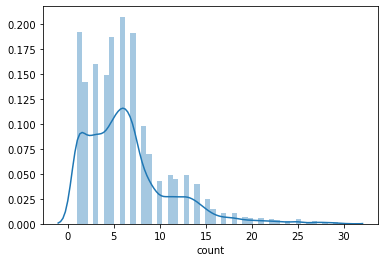

In [333]:
sns.distplot(trendingdate_df["count"])

### Data Transformation

Let's merge US videos dataset and category dataset and transform trending_data into timestamp

In [334]:
US1 =US.merge(category,how="inner",left_on=["category_id","country"],right_on=["category_id","country_code"])
US1["trending_date1"] = US1["trending_date"].apply(lambda x: pd.Timestamp(int("20"+x[0:2]),int(x[-2:]),int(x[3:5]),0))

We extract the columns we'll use 

In [335]:
columns = ["video_id","trending_date1","channel_title","publish_time","views","likes","dislikes","comment_count","category_title"]
US1 = US1[columns].copy()

Here we only keep videos which have more than 10 trending days. 

In [336]:
videos = trendingdate_df[trendingdate_df["count"].values>=10].video_id
US2 = US1[ US1.video_id.isin(videos.values)]

We'll standardize numerical data. Here we standardize views,likes,dislikes and comment counts with zero mean and unit variace. We'll only use views later.

In [337]:
def standardize(data):
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    transformed = scaler.transform(data)
    return scaler,transformed
scaler_views, US_views = standardize(US2.views.values.reshape(-1,1))
#scaler_likes, US_likes = standardize(US2.likes.values.reshape(-1,1))
#scaler_dislikes, US_dislikes = standardize(US2.dislikes.values.reshape(-1,1))
#scaler_comments, US_comments = standardize(US2.comment_count.values.reshape(-1,1))

We create the dataframe we'll use in building model.

In [338]:
US3 = pd.DataFrame()
US3["trending_date1"] = US2["trending_date1"]
US3["video_id"] = US2["video_id"]
US3["views"] = US_views
#US3["likes"] = US_likes
#US3["dislikes"] = US_dislikes
#US3["comment_count"] = US_comments
US3.reset_index(inplace=True)
US3.head()

,index,trending_date1,video_id,views
0,592,2017-12-20,kwvbLx9M6-s,-0.370806
1,607,2017-12-21,kwvbLx9M6-s,-0.362491
2,622,2017-12-22,sXP6vliZIHI,-0.359835
3,623,2017-12-22,dwEKqAwoz0Y,-0.354888
4,625,2017-12-22,kwvbLx9M6-s,-0.359453


In [339]:
US3.drop("index",axis=1,inplace=True)
US3.head()

,trending_date1,video_id,views
0,2017-12-20,kwvbLx9M6-s,-0.370806
1,2017-12-21,kwvbLx9M6-s,-0.362491
2,2017-12-22,sXP6vliZIHI,-0.359835
3,2017-12-22,dwEKqAwoz0Y,-0.354888
4,2017-12-22,kwvbLx9M6-s,-0.359453


We extract the first 9days views in x and 10th day views in y as label.

In [340]:

x=[]
y=[]
category = []
for v in videos:
    row=[]
    temp_df = US3[US3["video_id"]==v].sort_values(by="trending_date1")
    #print (temp_df)
    seq = temp_df.views[0:9].index #first 9 views as input
        
    for s in seq:
        #print (US3.iloc[s].values[2:])
        row.append(US3.iloc[s].values[2:])
    x.append(row)
    nextstep = temp_df.views[9:10].values # the 10th views as output
    y.append(nextstep)
    

We shape input x as (len(x),timesteps,dimensions), here timesteps is 9 because we use the first 9 views to predict the 10th views. The dimension is 1 because we only use views to predict.

In [341]:

x = np.reshape(x,(len(x),9,1)) #input shape(len(x),timesteps,dimensions)
print (x.shape)
y = np.reshape(y,(-1,1))
print (y.shape)
x = x.astype('float64')
y = y.astype('float64')

(1209, 9, 1)
(1209, 1)


### Data Modeling

Spliting train and test data.

In [342]:
from sklearn.model_selection import ShuffleSplit,train_test_split
x_train,x_testall,y_train,y_testall = train_test_split(x,y,test_size=0.4,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_testall,y_testall,test_size=0.5,random_state=42)

In [343]:
x_train.shape
x_val.shape
x_test.shape

(242, 9, 1)

In [344]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.layers.core import Dense, Activation, Dropout

Build up Lstm model by Keras. We use mean square error as loss function and RMSprop as optimizer algorithm.

In [345]:
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(9, 1),activation='tanh'))#32 is output,  input shape是3维: (Batch_size, Time_step, Input_Sizes),
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=False,activation='tanh'))
model.add(Dense(1, activation='linear'))#1 is output

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [346]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=50, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.4797
Epoch 00001: val_loss improved from inf to 0.04399, saving model to weights.best.from_scratch.hdf5
12/12 [==============================] - 1s 95ms/step - loss: 0.4797 - val_loss: 0.0440
Epoch 2/50
10/12 [========================>.....] - ETA: 0s - loss: 0.1263
Epoch 00002: val_loss did not improve from 0.04399
12/12 [==============================] - 0s 24ms/step - loss: 0.1343 - val_loss: 0.1800
Epoch 3/50
10/12 [========================>.....] - ETA: 0s - loss: 0.1013
Epoch 00003: val_loss did not improve from 0.04399
12/12 [==============================] - 0s 22ms/step - loss: 0.0996 - val_loss: 0.2587
Epoch 4/50
10/12 [========================>.....] - ETA: 0s - loss: 0.2250
Epoch 00004: val_loss did not improve from 0.04399
12/12 [==============================] - 0s 23ms/step - loss: 0.2205 - val_loss: 0.1086
Epoch 5/50
10/12 [========================>.....] - ETA: 0s - loss: 0.1156
Epoch 00005: val_loss

Epoch 38/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0252
Epoch 00038: val_loss did not improve from 0.00094
12/12 [==============================] - 0s 22ms/step - loss: 0.0231 - val_loss: 0.0028
Epoch 39/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0145
Epoch 00039: val_loss did not improve from 0.00094
12/12 [==============================] - 0s 23ms/step - loss: 0.0294 - val_loss: 0.0259
Epoch 40/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0268
Epoch 00040: val_loss improved from 0.00094 to 0.00062, saving model to weights.best.from_scratch.hdf5
12/12 [==============================] - 0s 25ms/step - loss: 0.0240 - val_loss: 6.1870e-04
Epoch 41/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0148
Epoch 00041: val_loss did not improve from 0.00062
12/12 [==============================] - 0s 23ms/step - loss: 0.0139 - val_loss: 0.0070
Epoch 42/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0067
Epoch 00

In [347]:
model.load_weights('weights.best.from_scratch.hdf5')

In [348]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)
# invert predictions
predict_train = scaler_views.inverse_transform(predict_train)
y_train = scaler_views.inverse_transform(y_train)
predict_test = scaler_views.inverse_transform(predict_test)
y_test= scaler_views.inverse_transform(y_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_test, y_test))
print('Val Score: %.2f RMSE' % (valScore))

Train Score: 372525.46 RMSE
Val Score: 338778.80 RMSE


In [349]:
predict = scaler_views.inverse_transform(model.predict(x_test))

print ("the demo predict is %s" %(predict.astype('int')[0:10]))
print ("the demo true is %s" %(y_test.astype('int')[0:10]))
#print (mean_squared_error(predict,true))

the demo predict is [[  695133]
 [13123127]
 [ 1407892]
 [ 3175983]
 [  390882]
 [  482648]
 [  947383]
 [  954410]
 [ 1640530]
 [ 4352690]]
the demo true is [[  582878]
 [12888317]
 [ 1480692]
 [ 3540976]
 [  219635]
 [  334691]
 [  883015]
 [  886899]
 [ 1706292]
 [ 4459181]]


The median of y_test is 1352392 , the rmse is about 391828(slightly difference for each training process
), that means about 50% views have predict error less than 27%.

In [350]:
pd.DataFrame(y_test).describe()

,0
count,2.420000e+02
mean,3.747867e+06
std,7.040313e+06
min,1.289110e+05
25%,6.070085e+05
50%,1.352392e+06
75%,3.696408e+06
max,5.754206e+07


### More Test and Discussion
1. For shorter time sequence, will the prediction do better or worse? 
I have tested timestep=4 and got RMSE on trainset is 817809,on testset is 305374 . We have a better performance in predict shorter time sequence probably because of we have more data of 4 sequence days than 9 sequence days. 
2. If adding likes, dislikes,comment count to training, will the model perform better?
We keep timestep =4 and set dimension =4 and add more 3 columns(likes,dislikes,comment_counts) and got RMSE on trainset is 569316 ,on testset is 373221 We got a better performance on trainset while worse performance on testset. 

We come to a conclusion that more training data will do good for the result and adding more dimensions does not necessarily yield in a better result.

Thank you for reading. Have fun to try!